# Стоимость подержанного автомобиля

#### Цель проекта: разработать модель предсказания стоимости автомобиля на вторичном рынке.

## 1. Предобработка данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
test = pd.read_csv('test.csv')

In [3]:
test.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [4]:
train = pd.read_csv('train.csv')
train.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [5]:
example = pd.read_csv('sample_submission.csv')
example.head(5)

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


In [6]:
example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           110058 non-null  object 
 1   sellingprice  110058 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


In [7]:
test.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'saledate'],
      dtype='object')

In [8]:
train.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'saledate'],
      dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


**Оценим наличие полных и неявных дубликатов**

In [10]:
train.duplicated().sum()

0

In [11]:
train['vin'].duplicated().sum()

0

**Оценим наличие неявных дубликатов или пропусков в колонке year**

In [12]:
train['year'].drop_duplicates().sort_values()

250627    1982
106264    1983
191684    1984
31280     1985
31287     1986
7349      1987
6666      1988
3756      1989
8779      1990
4097      1991
10128     1992
2479      1993
475       1994
934       1995
166       1996
414       1997
127       1998
89        1999
8         2000
86        2001
76        2002
3         2003
17        2004
9         2005
13        2006
4         2007
19        2008
58        2009
6         2010
0         2011
2         2012
5         2013
1         2014
62        2015
Name: year, dtype: int64

**Пропуски в колонках condition и odometer можно заменить медианным значением**

In [14]:
median_condition = train['condition'].median()
median_odometer = train['odometer'].median()

In [15]:
train_mod = train
train_mod['condition']=train_mod['condition'].fillna(median_condition)
train_mod['odometer']=train_mod['odometer'].fillna(median_odometer)
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     440236 non-null  float64
 9   odometer      440236 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


**Исследуем данные в категориальных колонках**

In [16]:
train_mod['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'pontiac', 'Hyundai', nan,
       'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac', 'GMC', 'Saab',
       'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen', 'BMW',
       'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep', 'Lexus',
       'mercedes', 'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo', 'Audi',
       'MINI', 'Isuzu', 'Mitsubishi', 'smart', 'Pontiac', 'Porsche',
       'subaru', 'ford', 'Land Rover', 'chrysler', 'Saturn', 'mazda',
       'dodge', 'Ram', 'Oldsmobile', 'hyundai', 'Mercury', 'Bentley',
       'toyota', 'lincoln', 'Fisker', 'nissan', 'chevrolet', 'honda',
       'porsche', 'mitsubishi', 'lexus', 'bmw', 'Maserati', 'acura',
       'jeep', 'mercury', 'Tesla', 'landrover', 'vw', 'cadillac', 'buick',
       'gmc truck', 'land rover', 'volkswagen', 'Rolls-Royce', 'audi',
       'Ferrari', 'suzuki', 'Plymouth', 'oldsmobile', 'Lamborghini',
       'gmc', 'Geo', 'ford truck', 'Aston Martin', 'plymouth', 'Daewoo',
      

Есть неявные дубликаты из-за строчных и заглавных букв. Переведём всё в строчные

In [17]:
lower_columns = ['make', 'model', 'trim', 'body', 'transmission', 'vin','state', 'color', 'interior', 'seller']
for i in lower_columns:
    train_mod[i]=train_mod[i].str.lower()
train_mod['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai', nan,
       'buick', 'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'saab',
       'dodge', 'mercedes-benz', 'toyota', 'volkswagen', 'bmw',
       'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'mercedes', 'scion', 'fiat', 'suzuki', 'mazda', 'volvo', 'audi',
       'mini', 'isuzu', 'mitsubishi', 'smart', 'porsche', 'land rover',
       'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker',
       'maserati', 'tesla', 'landrover', 'vw', 'gmc truck', 'rolls-royce',
       'ferrari', 'plymouth', 'lamborghini', 'geo', 'ford truck',
       'aston martin', 'daewoo', 'mercedes-b', 'dodge tk', 'mazda tk',
       'dot', 'airstream'], dtype=object)

In [18]:
train_mod['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai', nan,
       'buick', 'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'saab',
       'dodge', 'mercedes-benz', 'toyota', 'volkswagen', 'bmw',
       'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'mercedes', 'scion', 'fiat', 'suzuki', 'mazda', 'volvo', 'audi',
       'mini', 'isuzu', 'mitsubishi', 'smart', 'porsche', 'land rover',
       'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker',
       'maserati', 'tesla', 'landrover', 'vw', 'gmc truck', 'rolls-royce',
       'ferrari', 'plymouth', 'lamborghini', 'geo', 'ford truck',
       'aston martin', 'daewoo', 'mercedes-b', 'dodge tk', 'mazda tk',
       'dot', 'airstream'], dtype=object)

Кроме того, есть разные написания компаний-производителей в колонке make, которые довольно просто привести к одному виду

In [19]:
def make_duplicates(name):
    if (name=='mercedes-benz') or (name=='mercedes-b'):
        return 'mercedes'
    elif name=='mazda tk':
        return 'mazda'
    elif name == 'vw':
        return 'volkswagen'
    elif name == 'gmc truck':
        return 'gmc'
    elif name == 'ford truck':
        return 'ford'
    elif name == 'airstream':
        return 'mercedes'
    elif name == 'dodge tk':
        return 'dodge'
    else:
        return name

In [20]:
train_mod['make']=train_mod['make'].apply(make_duplicates)

**Исследуем уникальные значения в других колонках**

In [21]:
train_mod['model'].unique()

array(['edge', 'fusion', 'sentra', 'h2', 'mkz', 'g6', 'escape', 'elantra',
       'freestyle', nan, 'lucerne', 'windstar', 'silverado 1500',
       'murano', 'equinox', 'accord', 'civic', 'mdx', 'cts', 'taurus',
       'srx', 'yukon', '9-3', 'explorer', 'f-150', 'charger', 'armada',
       'gl-class', 'avalon', 'tahoe', 'malibu', 'passat', 'camry', 'flex',
       '3 series', 'q50', 'altima', 'mustang', '300', 'sonata',
       'envoy xl', 'rogue', 'accent', 'maxima', 'forte', 'xf', 'outback',
       'grand caravan', 'e-class', 'cherokee', 'impala', 'optima',
       '5 series', 'expedition', 'is 250', 'mks', '200', 'veloster',
       'golf', 'rav4', 'e300dt', 'five hundred', 'g coupe',
       'grand cherokee', 'x-type', 'g convertible', 'tacoma', 'xa',
       'g sedan', 'tl', 'liberty', 'soul', '500l', 'town and country',
       'hhr', 'wrangler', 'reno', 'suburban', 'pt cruiser', 'gx 460',
       'sienna', 'sl-class', 'envoy', 'patriot', 'e-series van', 'versa',
       'aspen', 'm', 'co

In [22]:
train_mod['trim'].unique()

array(['sel', 'se', '2.0 sl', ..., '2.5 x l.l.bean edition',
       '3500 high roof 140 wb', '4x4 v6 xlt sport'], dtype=object)

In [23]:
train_mod['body'].unique()

array(['suv', 'sedan', nan, 'wagon', 'minivan', 'extended cab',
       'regular cab', 'coupe', 'supercrew', 'convertible', 'crew cab',
       'supercab', 'hatchback', 'g coupe', 'g convertible', 'access cab',
       'g sedan', 'e-series van', 'quad cab', 'tsx sport wagon', 'van',
       'cts coupe', 'koup', 'king cab', 'double cab', 'elantra coupe',
       'crewmax cab', 'genesis coupe', 'g37 coupe', 'club cab',
       'beetle convertible', 'mega cab', 'regular-cab', 'xtracab',
       'q60 coupe', 'promaster cargo van', 'cts-v coupe', 'cts wagon',
       'cab plus 4', 'g37 convertible', 'transit van', 'q60 convertible',
       'cab plus', 'ram van', 'granturismo convertible', 'cts-v wagon'],
      dtype=object)

In [24]:
train_mod['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

In [25]:
train_mod['color'].unique()

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', '—', 'red',
       'brown', 'green', 'beige', 'orange', nan, 'off-white', 'burgundy',
       'yellow', 'charcoal', 'purple', 'turquoise', 'lime', 'pink'],
      dtype=object)

In [26]:
train_mod['interior'].unique()

array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', nan,
       'blue', 'white', 'silver', 'red', 'green', 'gold', 'purple',
       'orange', 'burgundy', 'yellow'], dtype=object)

In [27]:
train_mod['seller'].unique()

array(['santander consumer', 'ars/avis budget group',
       'nissan-infiniti lt', ..., 'autostar enterprises',
       'kocourek nissan', 'studio city auto group'], dtype=object)

Заполним пропуски в категориальных колонках. Их можно заполнить символом '—'. Он уже присутствует в разных колонках, таким образом, отсутствие данных будет везде одинково кодироваться.

In [28]:
fillna_columns=['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']
for i in fillna_columns:
    train_mod[i]=train_mod[i].fillna('—')
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   trim          440236 non-null  object 
 4   body          440236 non-null  object 
 5   transmission  440236 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     440236 non-null  float64
 9   odometer      440236 non-null  float64
 10  color         440236 non-null  object 
 11  interior      440236 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


**Теперь пропусков не осталось. Но есть графа saledate, которую надо привести к типу даты и извлечь из неё данные о дате продажи.**

In [30]:
train_mod['saledate'].head(1)

0    Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
Name: saledate, dtype: object

In [31]:
train_mod['saledate']=pd.to_datetime(train_mod['saledate'], format='%a %b %d %Y', exact=False)

In [32]:
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          440236 non-null  int64         
 1   make          440236 non-null  object        
 2   model         440236 non-null  object        
 3   trim          440236 non-null  object        
 4   body          440236 non-null  object        
 5   transmission  440236 non-null  object        
 6   vin           440236 non-null  object        
 7   state         440236 non-null  object        
 8   condition     440236 non-null  float64       
 9   odometer      440236 non-null  float64       
 10  color         440236 non-null  object        
 11  interior      440236 non-null  object        
 12  seller        440236 non-null  object        
 13  sellingprice  440236 non-null  int64         
 14  saledate      440236 non-null  datetime64[ns]
dtypes: datetime64[ns]

In [33]:
train_mod.head(1)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-02
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-25
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-10
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-17
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-03


**Вынесем отдельно колонку с целевым признаком, а колонку с идентификатором (vin) уберём за ненадобностью из обучающих данных**

In [32]:
target_train = train_mod['sellingprice']

In [33]:
features_train = train_mod.drop(columns=['vin', 'sellingprice'],axis=1)

**Проверим данные на мультиколлинеарность**

In [34]:
train_mod.drop(columns=['vin'],axis=1).corr()

,year,condition,odometer,sellingprice
year,1.000000,0.534360,-0.774199,0.586847
condition,0.534360,1.000000,-0.524827,0.529901
odometer,-0.774199,-0.524827,1.000000,-0.582933
sellingprice,0.586847,0.529901,-0.582933,1.000000


Коррелиция довольно большая между годом производства автомобиля и одометром, однако, она всё ещё далека от 1 и не должна помешать обучению модели.

**Исследуем категориальные признаки - построим гистограммы распределения количества уникальных значений по столбцам**

<AxesSubplot:>

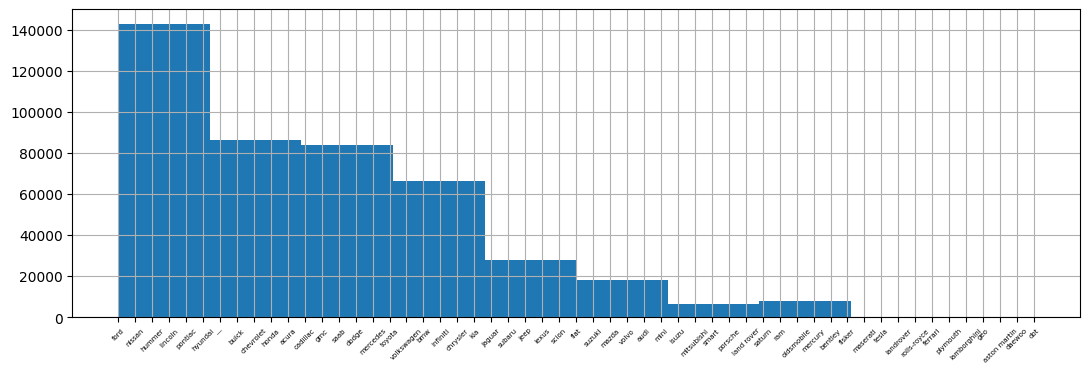

In [36]:
features_train['make'].hist(xlabelsize=5, xrot=45, figsize = (13,4))

<AxesSubplot:>

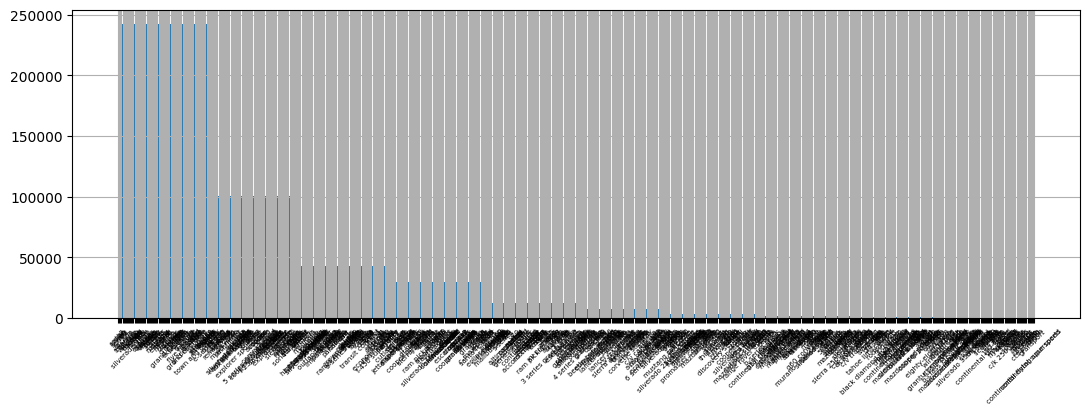

In [37]:
features_train['model'].hist(xlabelsize=5, xrot=45, figsize = (13,4))

<AxesSubplot:>

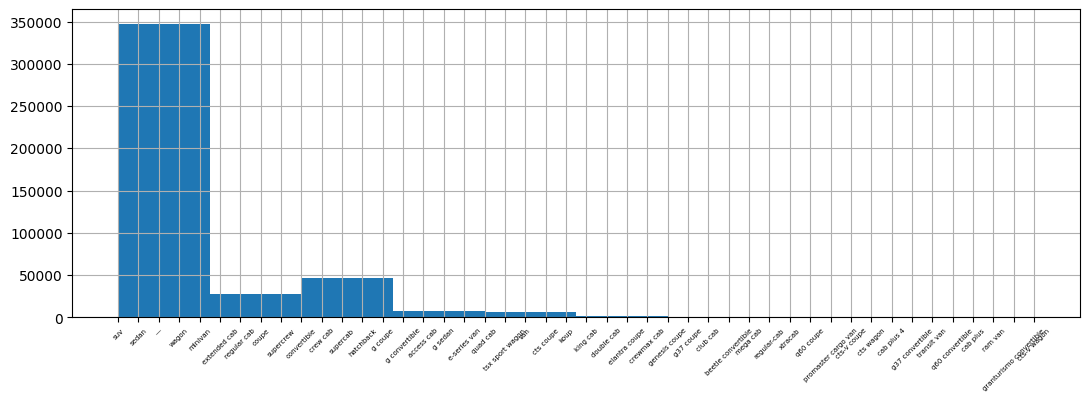

In [38]:
features_train['body'].hist(xlabelsize=5, xrot=45, figsize = (13,4))

<AxesSubplot:>

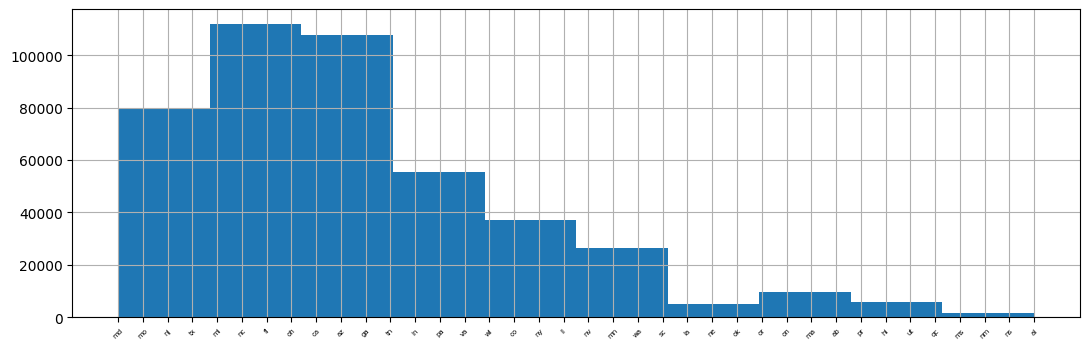

In [39]:
features_train['state'].hist(xlabelsize=5, xrot=45, figsize = (13,4))

**Там, где уникальных значений очень много - трудно построить хороший график, по которому было бы понятно, какие уникальные значения встречаются часто. Поэтому сделаем таблички для категориальных данных, в которых посчитаем, как часто встречаются уникальные значения, и выведем знакчения самых часто встречающихся**

In [41]:
make_counts=pd.DataFrame(features_train['make'].value_counts()).reset_index().rename(
    columns={'index':'make','make':'make_counts'})
make_counts.head(30)

,make,make_counts
0,ford,74070
1,chevrolet,47818
2,nissan,42866
3,toyota,31711
4,dodge,24295
5,honda,21600
6,hyundai,17187
7,bmw,16254
8,kia,14325
9,chrysler,13796


In [42]:
model_counts=pd.DataFrame(features_train['model'].value_counts()).reset_index().rename(
    columns={'index':'model','model':'model_counts'})
model_counts.head(30)

,model,model_counts
0,altima,15454
1,f-150,11408
2,fusion,10244
3,camry,10000
4,escape,9447
5,focus,8222
6,—,8123
7,accord,7226
8,3 series,6406
9,impala,6305


In [43]:
trim_counts=pd.DataFrame(features_train['trim'].value_counts()).reset_index().rename(
    columns={'index':'trim','trim':'trim_counts'})
trim_counts.head(30)

,trim,trim_counts
0,base,43876
1,se,34498
2,lx,16511
3,limited,14516
4,lt,13431
5,xlt,13173
6,ls,10723
7,le,10231
8,gls,9707
9,s,9649


In [44]:
seller_counts=pd.DataFrame(features_train['seller'].value_counts()).reset_index().rename(
    columns={'index':'seller','seller':'seller_counts'})
seller_counts.head(30)

,seller,seller_counts
0,nissan-infiniti lt,15823
1,"ford motor credit company,llc",15276
2,the hertz corporation,14692
3,santander consumer,12230
4,avis corporation,10098
5,nissan infiniti lt,7964
6,wells fargo dealer services,7061
7,enterprise veh exchange/rental,5516
8,tdaf remarketing,5404
9,ge fleet services for itself/servicer,5368


In [45]:
body_counts=pd.DataFrame(features_train['body'].value_counts()).reset_index().rename(
    columns={'index':'body','body':'body_counts'})
body_counts.head(30)

,body,body_counts
0,sedan,190861
1,suv,113042
2,hatchback,20715
3,minivan,20114
4,coupe,13896
5,crew cab,12823
6,wagon,12600
7,—,10393
8,convertible,8183
9,supercrew,7081


In [46]:
state_counts=pd.DataFrame(features_train['state'].value_counts()).reset_index().rename(
    columns={'index':'state','state':'state_counts'})
state_counts.head(20)

,state,state_counts
0,fl,65618
1,ca,57407
2,pa,42462
3,tx,36104
4,ga,27141
5,nj,22102
6,il,18651
7,nc,17051
8,oh,16959
9,tn,16156


**Мы видим, что часто встречающиеся значения - встречаются тысячи раз. Поэтому поставим порог больше 1000, чтобы оставить только часто встречающиеся значения категориальных признаков. Составим список category_list, в который запишем все уникальные значения, которые хотим оставить для обученя модели.**

In [47]:
category_list = []
for i in range(len(make_counts)):
    if make_counts['make_counts'][i]>1000:
        category_list.append(make_counts['make'][i])
for j in range(len(model_counts)):
    if model_counts['model_counts'][j]>1000:
        category_list.append(model_counts['model'][j])
for k in range(len(trim_counts)):
    if trim_counts['trim_counts'][k]>1000:
        category_list.append(trim_counts['trim'][k])
for l in range(len(body_counts)):
    if body_counts['body_counts'][l]>1000:
        category_list.append(body_counts['body'][l])
for m in range(len(state_counts)):
    if state_counts['state_counts'][m]>1000:
        category_list.append(state_counts['state'][m])
for n in range(len(seller_counts)):
    if seller_counts['seller_counts'][n]>3000:
        category_list.append(seller_counts['seller'][n])
category_list

['ford',
 'chevrolet',
 'nissan',
 'toyota',
 'dodge',
 'honda',
 'hyundai',
 'bmw',
 'kia',
 'chrysler',
 'mercedes',
 'infiniti',
 'jeep',
 'volkswagen',
 'lexus',
 'gmc',
 '—',
 'mazda',
 'cadillac',
 'acura',
 'audi',
 'lincoln',
 'buick',
 'subaru',
 'pontiac',
 'ram',
 'mitsubishi',
 'volvo',
 'mini',
 'saturn',
 'mercury',
 'land rover',
 'scion',
 'jaguar',
 'porsche',
 'altima',
 'f-150',
 'fusion',
 'camry',
 'escape',
 'focus',
 '—',
 'accord',
 '3 series',
 'impala',
 'grand caravan',
 'explorer',
 'civic',
 'g sedan',
 'corolla',
 'malibu',
 'sonata',
 'maxima',
 'cruze',
 'elantra',
 'silverado 1500',
 'town and country',
 'edge',
 'rogue',
 'sentra',
 'c-class',
 'equinox',
 'mustang',
 'taurus',
 'grand cherokee',
 'jetta',
 'charger',
 'optima',
 '5 series',
 '200',
 'avenger',
 '300',
 'e-class',
 'wrangler',
 'odyssey',
 'sorento',
 'passat',
 '1500',
 'rav4',
 'cr-v',
 'versa',
 'journey',
 'tahoe',
 'expedition',
 'mazda3',
 'sienna',
 'murano',
 'forte',
 'soul',


**Теперь сделаем функцию, которая будет оставлять часто встречающиеся значения (из списка category_list), а остальные заменять на знак '—', аналогично пропускам.**

In [48]:
def column_modification(column):
    if column in category_list:
        return column
    else:
        return '—'

**Применим эту функцию, ко всем столбцам с большим количеством уникальных категориальных значений**

In [49]:
features_train['make'] = features_train['make'].apply(column_modification)
features_train['make'].unique()

array(['ford', 'nissan', '—', 'lincoln', 'pontiac', 'hyundai', 'buick',
       'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'dodge',
       'mercedes', 'toyota', 'volkswagen', 'bmw', 'infiniti', 'chrysler',
       'kia', 'jaguar', 'subaru', 'jeep', 'lexus', 'scion', 'mazda',
       'volvo', 'audi', 'mini', 'mitsubishi', 'porsche', 'land rover',
       'saturn', 'ram', 'mercury'], dtype=object)

In [50]:
features_train['model'] = features_train['model'].apply(column_modification)
features_train['model'].unique()

array(['edge', 'fusion', 'sentra', '—', 'mkz', 'g6', 'escape', 'elantra',
       'silverado 1500', 'murano', 'equinox', 'accord', 'civic', 'mdx',
       'cts', 'taurus', 'srx', 'yukon', 'explorer', 'f-150', 'charger',
       'tahoe', 'malibu', 'passat', 'camry', '3 series', 'altima',
       'mustang', '300', 'sonata', 'rogue', 'accent', 'maxima', 'forte',
       'outback', 'grand caravan', 'e-class', 'impala', 'optima',
       '5 series', 'expedition', 'is 250', '200', 'rav4', 'g coupe',
       'grand cherokee', 'g sedan', 'tl', 'liberty', 'soul',
       'town and country', 'wrangler', 'suburban', 'sienna', 'patriot',
       'e-series van', 'versa', 'corolla', 'focus', 'traverse',
       'pathfinder', 'silverado 2500hd', 'ram pickup 1500', '4runner',
       'sorento', 'odyssey', 'camaro', 'x5', 'caliber', 'journey',
       'prius', 'jetta', 'avenger', 'cooper', 'f-250 super duty',
       'rx 350', 'cruze', 'm-class', 'c-class', 'cr-v', 'sierra 1500',
       'es 350', 'highlander', 'ran

In [51]:
features_train['trim'] = features_train['trim'].apply(column_modification)
features_train['trim'].unique()

array(['sel', 'se', '—', 'base', 'gls', 'limited', 'ls', 'sl', 'lt', 'lx',
       'luxury', 'denali', 'xlt', 'sxt', 'le', 'titanium', 'sport',
       'work truck', '328i', 'ltz', 'premium', '2.5', 'v6', 'slt', 'sv',
       '3.5 s', '2.5 s', 's', 'lt fleet', 'laredo', 'xle', 'ex',
       'g37 journey', 'xl', 'e-250', '1.8 s', '1lt', 'ls fleet', 'xls',
       'touring', 'sr5', 'g37x', 'sle', 'se pzev', 'r/t', '2lt', 'gt',
       'es', 'ex-l', '3.2', 'lariat', '1500', 'st', 'fx4', 'lt1', '+',
       '3.5 sv', 'i sport', 'c250 sport', '1.6 sv', 'tundra', 'journey',
       'edge', 'outback', 'sc', 'ram', 'wagon'], dtype=object)

In [52]:
features_train['seller'] = features_train['seller'].apply(column_modification)
features_train['seller'].unique()

array(['santander consumer', '—', 'nissan-infiniti lt',
       'ford motor credit company,llc', 'wells fargo dealer services',
       'avis corporation', 'ahfc/honda lease trust/hvt, inc. eot',
       'ford motor credit company,llc pd',
       'credit acceptance corp/vrs/southfield',
       'toyota financial services', 'avis budget group',
       'financial services remarketing (lease)',
       'kia motors america, inc', 'ge fleet services for itself/servicer',
       'the hertz corporation', 'mercedes-benz financial services',
       'gm financial', 'jpmorgan chase bank,n.a.', 'nissan infiniti lt',
       'gm remarketing', 'hyundai motor finance', 'dt credit corporation',
       'lexus financial services', 'tdaf remarketing',
       'capital one auto finance', 'enterprise veh exchange/rental',
       'r hollenshead auto sales inc', 'chrysler capital',
       'world omni financial corporation', 'lease plan usa',
       'dtg operations inc'], dtype=object)

In [53]:
features_train['body'] = features_train['body'].apply(column_modification)
features_train['body'].unique()

array(['suv', 'sedan', '—', 'wagon', 'minivan', 'extended cab',
       'regular cab', 'coupe', 'supercrew', 'convertible', 'crew cab',
       'supercab', 'hatchback', 'g coupe', 'g sedan', 'e-series van',
       'quad cab', 'van', 'double cab'], dtype=object)

In [54]:
features_train['state'] = features_train['state'].apply(column_modification)
features_train['state'].unique()

array(['md', 'mo', 'nj', 'tx', 'mi', 'nc', 'fl', 'oh', 'ca', 'az', 'ga',
       'tn', 'in', 'pa', 'va', 'wi', 'co', 'ny', 'il', 'nv', 'mn', 'wa',
       'sc', 'la', 'ne', '—', 'on', 'ma', 'pr', 'ut', 'ms'], dtype=object)

Так как для обучения модели мы не можем использовать колонку saledate с форматом datetime, извлечём из неё год и месяц, и создадим новые колонки с этими значениями

In [55]:
features_train['year_selling']=pd.DatetimeIndex(features_train['saledate']).year
features_train['month_selling']=pd.DatetimeIndex(features_train['saledate']).month

In [57]:
# Saledate можно удалить
features_train=features_train.drop(columns=['saledate'])

In [59]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   year           440236 non-null  int64  
 1   make           440236 non-null  object 
 2   model          440236 non-null  object 
 3   trim           440236 non-null  object 
 4   body           440236 non-null  object 
 5   transmission   440236 non-null  object 
 6   state          440236 non-null  object 
 7   condition      440236 non-null  float64
 8   odometer       440236 non-null  float64
 9   color          440236 non-null  object 
 10  interior       440236 non-null  object 
 11  seller         440236 non-null  object 
 12  year_selling   440236 non-null  int64  
 13  month_selling  440236 non-null  int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 47.0+ MB


## 2. Подготовка признаков для обучения модели

**Кодирование категориальных признаков**

In [60]:
encoder=OneHotEncoder(sparse_output=False, drop='first')
categories = ['make','model', 'trim', 'body','transmission','state', 'color', 'interior', 'seller']

In [61]:
encoder.fit(features_train[categories])
new_feature_names = encoder.get_feature_names_out(
    ['make','model', 'trim', 'body','transmission','state', 'color', 'interior', 'seller'])

In [62]:
train_cod = pd.DataFrame(encoder.transform(features_train[categories]), columns = new_feature_names)
train_cod.head(5)

,make_audi,make_bmw,make_buick,make_cadillac,make_chevrolet,make_chrysler,make_dodge,make_ford,make_gmc,make_honda,...,seller_nissan infiniti lt,seller_nissan-infiniti lt,seller_r hollenshead auto sales inc,seller_santander consumer,seller_tdaf remarketing,seller_the hertz corporation,seller_toyota financial services,seller_wells fargo dealer services,seller_world omni financial corporation,seller_—
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Масштабирование численных признаков**

Из таблицы features_train выберем колонки, содержащие численные признаки - обозначим их как features_keep, так как после масштабирования мы их оставим, и объединим с множеством колонок, полученных ранее кодированием при помощи OHE.

In [63]:
features_keep = ['year', 'condition', 'odometer', 'year_selling', 'month_selling']

In [64]:
scaler=StandardScaler()
scaler.fit(features_train[features_keep])
features_scaled =pd.DataFrame(scaler.transform(features_train[features_keep]), columns = features_keep)
features_scaled.head(5)

,year,condition,odometer,year_selling,month_selling
0,0.241305,0.820315,0.797543,0.328663,0.672419
1,0.995464,0.075721,-0.696844,0.328663,-0.560021
2,0.492692,-1.307095,-0.611205,0.328663,0.672419
3,-1.769785,-0.668872,1.175963,0.328663,0.672419
4,-0.764240,-1.519836,1.108871,0.328663,-0.560021


Создадим таблицу feat_train_mod, которая будет содержать масштабированные признаки и закодированные категориальные.

In [65]:
feat_train_mod = pd.concat([features_scaled, train_cod], axis=1)
feat_train_mod.head(5)

,year,condition,odometer,year_selling,month_selling,make_audi,make_bmw,make_buick,make_cadillac,make_chevrolet,...,seller_nissan infiniti lt,seller_nissan-infiniti lt,seller_r hollenshead auto sales inc,seller_santander consumer,seller_tdaf remarketing,seller_the hertz corporation,seller_toyota financial services,seller_wells fargo dealer services,seller_world omni financial corporation,seller_—
0,0.241305,0.820315,0.797543,0.328663,0.672419,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.995464,0.075721,-0.696844,0.328663,-0.560021,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.492692,-1.307095,-0.611205,0.328663,0.672419,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.769785,-0.668872,1.175963,0.328663,0.672419,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.764240,-1.519836,1.108871,0.328663,-0.560021,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Проверим полученную таблицу на мультиколлинеарность данных - для этого посчитаем корреляции всех столбцов друг с другом

In [66]:
correlations = feat_train_mod.corr()
correlations.head(5)

,year,condition,odometer,year_selling,month_selling,make_audi,make_bmw,make_buick,make_cadillac,make_chevrolet,...,seller_nissan infiniti lt,seller_nissan-infiniti lt,seller_r hollenshead auto sales inc,seller_santander consumer,seller_tdaf remarketing,seller_the hertz corporation,seller_toyota financial services,seller_wells fargo dealer services,seller_world omni financial corporation,seller_—
year,1.000000,0.534360,-0.774199,0.116470,-0.049239,-0.014540,-0.028413,-0.041054,-0.059591,-0.001833,...,0.072397,0.097408,-0.014369,-0.034278,0.000282,0.129771,0.038913,-0.042973,0.043041,-0.318423
condition,0.534360,1.000000,-0.524827,0.021105,-0.005164,0.006130,0.038863,-0.015413,-0.012015,-0.061671,...,0.064602,0.068223,0.035659,-0.084508,0.008569,-0.003158,0.000851,-0.066439,0.035733,-0.125557
odometer,-0.774199,-0.524827,1.000000,-0.087861,0.043035,-0.005592,-0.014448,0.019645,0.033786,0.058696,...,-0.097136,-0.130697,-0.003438,0.051897,-0.002118,-0.046644,-0.051625,0.044220,-0.056207,0.273413
year_selling,0.116470,0.021105,-0.087861,1.000000,-0.824302,-0.002336,-0.004281,-0.003364,-0.012405,-0.008449,...,0.011055,0.025571,0.031205,-0.011217,0.009516,0.041498,-0.003314,-0.025824,0.013592,-0.070084
month_selling,-0.049239,-0.005164,0.043035,-0.824302,1.000000,0.005866,0.009794,0.003904,0.005638,0.002485,...,-0.006335,-0.009888,-0.016889,0.005096,-0.011824,0.011066,0.012405,0.008802,-0.003541,0.043487


Теперь выведем на экран пары признаков с высокой корреляцией

In [67]:
for i in correlations.index:
    for j in correlations.index:
        if (correlations[i][j]>0.8) and (i!=j):
            print(i,'   ', j,'   ', correlations[i][j])

make_infiniti     seller_nissan infiniti lt     0.8063972924907985
make_mini     model_cooper     0.8313093487508743
model_cooper     make_mini     0.8313093487508743
model_e-series van     body_e-series van     1.0
model_g coupe     body_g coupe     1.0
model_g sedan     body_g sedan     1.0
body_e-series van     model_e-series van     1.0
body_g coupe     model_g coupe     1.0
body_g sedan     model_g sedan     1.0
seller_nissan infiniti lt     make_infiniti     0.8063972924907985


Мы видим, что у столбцов "model_e-series van" и "body_e-series van" корреляция равна 1, поэтому один из этих столбцов стоит убрать. То же самое имеем с "g coupe" и "g sedan". Остальные корреляции - меньше 0.9, оставим их как есть.

In [68]:
feat_train_mod = feat_train_mod.drop(
    columns=['body_e-series van', 'body_g coupe', 'body_g sedan'], axis=1)

## 3.Подбор моделей машинного обучения

**Обучим и проверим кросс-валидацией модель случайного леса с установками по умолчанию и числом деревьев =10 (для скорости)**

In [69]:
model = RandomForestRegressor(n_estimators=10)
scores=cross_val_score(model,feat_train_mod,target_train, scoring = 'neg_mean_absolute_percentage_error', cv=5)
print(scores)
scores.mean()

[-0.19280326 -0.23372381 -0.19303361 -0.19202846 -0.27487741]


-0.2172933123837034

Значение метрики отрицательно из-за того, что в cross-val-score доступно только neg_mean_absolute_percentage_error по причине "Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric." (см https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter )

Получилось неплохое значение MAPE. Возможно, его получится улучшить, если подобрать параметры модели. Однако, с таким большим количествои признаков подбор параметров будет идти очень долго. Используем параметры, подобранные в предыдущей версии тетрадки на данных, где кодировалось только 10 самых частых категорий из каждого столбца. Как проходил подбор параметров - в следующей ячейке.

In [184]:
#Не исполнять! Этот код исполнялся в прошлой версии тетрадки.

# best_n_est=0
# best_depth=0
# best_samp_split=0
# best_score=-1
# for i in range(10,60,10):
#     for j in range(1,9,2):
#         for k in range (2,10,2):
#             model = RandomForestRegressor(n_estimators=i, max_depth=j, min_samples_split=k)
#             scores=cross_val_score(model,feat_train_mod,target_train, scoring = 'neg_mean_absolute_percentage_error', cv=5)
#             score=scores.mean()
#             if score>best_score:
#                 best_n_est=i
#                 best_depth=j
#                 best_samp_split=k
#                 best_score=score
# best_n_est, best_depth, best_samp_split, best_score

(40, 7, 8, -0.4681957837375606)

Обучим модель с подобранными ранее параметрами: n_estimators=40, max_depth=7, min_samples_split=8.

In [70]:
model = RandomForestRegressor(n_estimators=40, max_depth=7, min_samples_split=8)
scores=cross_val_score(model,feat_train_mod,target_train, scoring = 'neg_mean_absolute_percentage_error', cv=5)
print(scores)
scores.mean()

[-0.47085856 -0.703273   -0.47083895 -0.47083701 -0.56815677]


-0.5367928563613373

Странно, что изначально MAPE была лучше. Возможно, дело было в max_depth, у которой по умолчанию значение "None". Попробуем установить max_depth=None.

In [71]:
model = RandomForestRegressor(n_estimators=40, max_depth=None, min_samples_split=8)
scores=cross_val_score(model,feat_train_mod,target_train, scoring = 'neg_mean_absolute_percentage_error', cv=5)
print(scores)
scores.mean()

[-0.18643584 -0.23704637 -0.18671786 -0.18573318 -0.25377993]


-0.209942637975521

Действительно, получилось немного улучшить MAPE, по сравнению с изначальным значением.

**Теперь попробуем подобрать линейную регрессию**

In [72]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

In [73]:
scores_lin = cross_val_score(linear_model, feat_train_mod, target_train, scoring = 'neg_mean_absolute_percentage_error', cv=5)
print(scores_lin)
scores_lin.mean()

[-6.69679870e-01 -8.42819729e-01 -1.59898997e+07 -6.67195057e-01
 -7.92168053e-01]


-3197980.541387515

Огромные значения метрики при линейной регрессии могут быть связаны с мультиколлинеарностью признаков. Попробуем исключить из анализа также те колонки,которые давали корреляцию по Пирсону более 0.8

In [74]:
feat_train_mod_linear = feat_train_mod.drop(
    columns=['seller_nissan infiniti lt', 'model_cooper'], axis=1)

In [75]:
scores_lin = cross_val_score(linear_model, feat_train_mod_linear, target_train, scoring = 'neg_mean_absolute_percentage_error', cv=5)
print(scores_lin)
scores_lin.mean()

[-6.70344605e-01 -8.43885288e-01 -1.61804473e+07 -1.64354891e+06
 -7.93733099e-01]


-3564799.711078421

Не получилось улучшить работу модели Линейной регрессии. Возможно, для этой модели слишком много фичей, и OneHotClassifier не подходит. Однако, при кодировании другим методом в предыдущих версиях, MAPE была ниже, чем значение, которое мы получили сейчас с помощью случайного леса.

**Для предсказания на тестовых данных обучим случайный лес с параметрами, которые мы сейчас подобрали - на всей тренировочной выборке.**

In [76]:
model = RandomForestRegressor(n_estimators=40, max_depth=None, min_samples_split=8)
model.fit(feat_train_mod,target_train)

RandomForestRegressor(min_samples_split=8, n_estimators=40)

## 4. Предобработка тестовых данных по алгоритму для тренировочных

In [77]:
features_test = test.drop(columns=['vin'],axis=1)

In [78]:
features_test['condition']=features_test['condition'].fillna(median_condition)
features_test['odometer']=features_test['odometer'].fillna(median_odometer)
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   state         110058 non-null  object 
 7   condition     110058 non-null  float64
 8   odometer      110058 non-null  float64
 9   color         109900 non-null  object 
 10  interior      109900 non-null  object 
 11  seller        110058 non-null  object 
 12  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 10.9+ MB


In [79]:
lower_columns = ['make', 'model', 'trim', 'body', 'transmission','state', 'color', 'interior', 'seller']
for i in lower_columns:
    features_test[i]=features_test[i].str.lower()
features_test['make'].unique()

array(['cadillac', 'gmc', 'nissan', 'chevrolet', 'volkswagen', 'hyundai',
       'ford', 'infiniti', 'subaru', 'kia', 'bmw', nan, 'mitsubishi',
       'dodge', 'oldsmobile', 'volvo', 'pontiac', 'acura', 'honda',
       'toyota', 'audi', 'jeep', 'lincoln', 'chrysler', 'mercedes-benz',
       'ram', 'scion', 'mercury', 'lexus', 'saturn', 'mazda', 'porsche',
       'mini', 'smart', 'buick', 'hummer', 'jaguar', 'fiat', 'saab',
       'suzuki', 'land rover', 'landrover', 'geo', 'chev truck',
       'bentley', 'isuzu', 'aston martin', 'maserati', 'daewoo', 'vw',
       'tesla', 'mercedes', 'ferrari', 'fisker', 'rolls-royce', 'lotus',
       'plymouth', 'hyundai tk', 'ford tk'], dtype=object)

In [80]:
features_test['saledate']=pd.to_datetime(features_test['saledate'], format='%a %b %d %Y', exact=False)

In [81]:
features_test['make']=features_test['make'].apply(make_duplicates)

In [82]:
features_test['make'] = features_test['make'].apply(column_modification)
features_test['model'] = features_test['model'].apply(column_modification)
features_test['trim'] = features_test['trim'].apply(column_modification)
features_test['seller'] = features_test['seller'].apply(column_modification)
features_test['body'] = features_test['body'].apply(column_modification)
features_test['state'] = features_test['state'].apply(column_modification)

In [83]:
features_test['year_selling']=pd.DatetimeIndex(features_test['saledate']).year
features_test['month_selling']=pd.DatetimeIndex(features_test['saledate']).month
features_test=features_test.drop(columns=['saledate'])
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   year           110058 non-null  int64  
 1   make           110058 non-null  object 
 2   model          110058 non-null  object 
 3   trim           110058 non-null  object 
 4   body           110058 non-null  object 
 5   transmission   97047 non-null   object 
 6   state          110058 non-null  object 
 7   condition      110058 non-null  float64
 8   odometer       110058 non-null  float64
 9   color          109900 non-null  object 
 10  interior       109900 non-null  object 
 11  seller         110058 non-null  object 
 12  year_selling   110058 non-null  int64  
 13  month_selling  110058 non-null  int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 11.8+ MB


In [84]:
fillna_columns=['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']
for i in fillna_columns:
    features_test[i]=features_test[i].fillna('—')
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   year           110058 non-null  int64  
 1   make           110058 non-null  object 
 2   model          110058 non-null  object 
 3   trim           110058 non-null  object 
 4   body           110058 non-null  object 
 5   transmission   110058 non-null  object 
 6   state          110058 non-null  object 
 7   condition      110058 non-null  float64
 8   odometer       110058 non-null  float64
 9   color          110058 non-null  object 
 10  interior       110058 non-null  object 
 11  seller         110058 non-null  object 
 12  year_selling   110058 non-null  int64  
 13  month_selling  110058 non-null  int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 11.8+ MB


In [85]:
test_cod = pd.DataFrame(encoder.transform(features_test[categories]), columns=new_feature_names)
test_cod

,make_audi,make_bmw,make_buick,make_cadillac,make_chevrolet,make_chrysler,make_dodge,make_ford,make_gmc,make_honda,...,seller_nissan infiniti lt,seller_nissan-infiniti lt,seller_r hollenshead auto sales inc,seller_santander consumer,seller_tdaf remarketing,seller_the hertz corporation,seller_toyota financial services,seller_wells fargo dealer services,seller_world omni financial corporation,seller_—
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [86]:
features_keep = ['year', 'condition', 'odometer', 'year_selling', 'month_selling']

In [87]:
features_test_scaled =pd.DataFrame(scaler.transform(features_test[features_keep]), columns = features_keep)

In [88]:
feat_test_mod = pd.concat([features_test_scaled, test_cod], axis=1)
feat_test_mod

,year,condition,odometer,year_selling,month_selling,make_audi,make_bmw,make_buick,make_cadillac,make_chevrolet,...,seller_nissan infiniti lt,seller_nissan-infiniti lt,seller_r hollenshead auto sales inc,seller_santander consumer,seller_tdaf remarketing,seller_the hertz corporation,seller_toyota financial services,seller_wells fargo dealer services,seller_world omni financial corporation,seller_—
0,-1.267013,-0.775243,0.908286,0.328663,-0.868131,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.995464,1.033056,-1.159092,0.328663,-0.560021,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.744078,1.245797,-1.055522,0.328663,-0.560021,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.744078,-1.200725,-0.209885,0.328663,-0.251911,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.744078,-0.562502,-0.695929,0.328663,0.672419,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110053,0.241305,0.394833,-0.042154,0.328663,-0.868131,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110054,0.995464,1.458538,-0.947991,0.328663,0.672419,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110055,-1.518399,-0.562502,1.040266,0.328663,-0.560021,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
110056,0.744078,-1.307095,-0.769035,0.328663,0.672419,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [89]:
feat_test_mod = feat_test_mod.drop(
    columns=['body_e-series van', 'body_g coupe', 'body_g sedan'], axis=1)

In [90]:
feat_test_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Columns: 327 entries, year to seller_—
dtypes: float64(327)
memory usage: 274.6 MB


## 5. Предсказания на тестовой выборке

In [91]:
predicted_prices = pd.DataFrame(model.predict(feat_test_mod), columns = ['sellingprice'])

In [92]:
output_table = pd.concat([test['vin'],predicted_prices], axis=1)
output_table

,vin,sellingprice
0,1g6dp567450124779,4090.072317
1,1gtw7fca7e1902207,22521.539461
2,jn8az1mw6dw303497,19370.074835
3,2g1wf5e34d1160703,9374.699069
4,1n6aa0ec3dn301209,22738.274944
...,...,...
110053,1j4aa2d17bl584330,16970.027347
110054,jthbf1d23e5007526,29637.564214
110055,1n4ba41e54c831950,4250.460075
110056,jn1az4eh3dm382431,20577.688402


## 6. Анализ важности признаков при использовании модели случайного леса

In [99]:
feature_importance=pd.DataFrame(data=model.feature_importances_, index=feat_train_mod.columns, columns=['importance'])
feature_importance.sort_values('importance', ascending=False).head(20)

,importance
odometer,0.375980
year,0.112760
body_sedan,0.049603
make_bmw,0.037042
condition,0.033403
body_hatchback,0.031729
make_mercedes,0.027824
model_—,0.024868
trim_—,0.020851
make_porsche,0.019460


Как видно, на первом и втором местах по важности для определения цены стоят пробег и год выпуска. Далее идут данные о производителе, состоянии автомобиля и модели.

**Вывод**: Мы обучили модель случайного леса и модель линейной регрессии после предобработки данных, в ходе которой мы оставили только наиболее частые значения категориальных признаков, которые встречались более 1000 раз, а остальные заменили на значение "-". Попробовав порядковое кодирование и OneHotEncoder, мы остановились на OHE. Итоговая модель показала на тестовой выборке значение MAPE, равное 18.35% и 18.60% (публичный и частный score на kaggle, соответственно). Наибольшее влияние на определение цены имеют пробег автомобиля и год выпуска.